In [149]:
import numpy as np
import pandas as pd
import json
import nltk
from scipy import stats

import matplotlib.pyplot as plt

%matplotlib inline

**Important this dataset evaluates only reviewers who have purchased five or more items from Amazon's pet supplies**

In [150]:
df = pd.read_json('https://graderdata.s3.amazonaws.com/reviews_Pet_Supplies_5.json', lines=True)
#lines = True is for parsing more than one block of data from your json

In [ ]:
meta_df = pd.read_json('meta_Pet_Supplies.json', lines=True)

In [ ]:
meta_df

In [ ]:
meta_df['sub_category'] = meta_df['category'].str[1:3].str.join('_')

In [ ]:
meta_df['sub_category']

In [ ]:
meta_df_dict = meta_df[['sub_category', 'asin']].drop_duplicates()

In [ ]:
df.columns

In [ ]:
df.head()

In [ ]:
print(f'Percent of unique reviewers: {(df["reviewerID"].nunique()/df.shape[0])}')

In [ ]:
df['reviewTime'] = pd.to_datetime(df['unixReviewTime'], unit='s')

In [ ]:
stats.describe(df['reviewerID'].value_counts())

(0, 60)

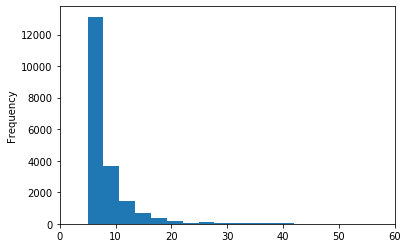

In [13]:
df['reviewerID'].value_counts().plot(kind='hist', bins = 50)
plt.xlim(left=0, right = 60)

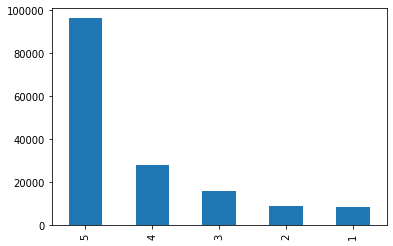

In [14]:
df['overall'].value_counts().plot(kind = 'bar')

**Map product code to subcategory**

In [15]:
np.sum(meta_df_dict['sub_category'].isnull())

0

In [16]:
df.shape

(157836, 9)

In [17]:
df = pd.merge(df, meta_df_dict,how='left', on = 'asin')

In [18]:
df['sub_category'].isnull()

0         False
1         False
2         False
3         False
4         False
          ...  
157831    False
157832    False
157833    False
157834    False
157835    False
Name: sub_category, Length: 157836, dtype: bool

There appears to be some categories where we do not have the proper labels. For those we'll use the product code as a place holder

In [19]:
df['sub_category'] = df['sub_category'].fillna(df['asin'])

In [20]:
df['sub_category']

0                                          
1                                          
2                                          
3                                          
4                                          
                        ...                
157831    Dogs_Collars, Harnesses & Leashes
157832    Dogs_Collars, Harnesses & Leashes
157833    Dogs_Collars, Harnesses & Leashes
157834    Dogs_Collars, Harnesses & Leashes
157835    Dogs_Collars, Harnesses & Leashes
Name: sub_category, Length: 157836, dtype: object

In [21]:
pd.set_option('display.max_rows', None) 
print(df['sub_category'].value_counts().sort_values(ascending=False))
pd.reset_option('display.max_rows')

Dogs_Toys                                                            13800
Dogs_Treats                                                           8756
Cats_Toys                                                             6965
Cats_Litter & Housebreaking                                           5142
Dogs_Health Supplies                                                  4245
Dogs_Grooming                                                         3946
Dogs_Food                                                             3471
Cats_Health Supplies                                                  3362
Cats_Food                                                             3192
Dogs_Collars, Harnesses & Leashes                                     3112
Cats_Beds & Furniture                                                 2848
Dogs_Feeding & Watering Supplies                                      2666
Fish & Aquatic Pets_Aquarium Pumps & Filters                          2531
Dogs_Litter & Housebreaki

**Assumption: **

Reviewers who review a product as 4 or 5 means they liked the product they purchased and those with 2 and 1 disliked the product. 


**Proposal**

Can we evaluate what product purchase tendencies by reviewers based upon products they've submitted reviews for

1) We need to create a "cart" for each reviewer so that each reviewer's aggregated purchases are placed into a list where the order is in the order of the review (assume that reviewers review products shortly after receiving them)

In [22]:
df.sort_values(by='reviewTime', inplace=True)

In [23]:
df

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,sub_category
52,AA7GFGJEAQYV5,B00005MF9T,Mrmxwll,"[257, 261]","i'm a cat lover of the first order, and presen...",5,Very Good Product,1009756800,2001-12-31,Cats_Litter & Housebreaking
109,AA7GFGJEAQYV5,B00005MF9V,Mrmxwll,"[16, 16]",the privacy tent is a very clever item.well ma...,2,Forget about it,1010188800,2002-01-05,Cats_Litter & Housebreaking
171,A3KJ80O8SLGJUL,B00005OU62,"Amazon Customer ""Book Lover""","[3, 3]",It is working GREAT!It's clean and you don't h...,5,It's Great!,1019088000,2002-04-18,Cats_Litter & Housebreaking
74,A1HGXLP6WATS4B,B00005MF9U,"F. D. Gillett ""Comparison Shopper""","[36, 37]",In a household with three adult cats I was con...,4,"It works, but............don't throw away your...",1019692800,2002-04-25,Cats_Litter &amp; Housebreaking
177,A64VV64H3KKYQ,B00005OU62,"qmsterling ""qmsterling""","[8, 8]",I have to admit the thought of dropping [$$] o...,5,"If odor is a concern, this baby is WORTH EVERY...",1027987200,2002-07-30,Cats_Litter & Housebreaking
...,...,...,...,...,...,...,...,...,...,...
154767,AJV2XY2105GOJ,B00EW2WG90,"Nancy ""Music Lover""","[0, 0]",This is a very well constructed pet carrier.I ...,5,Great!,1405987200,2014-07-22,Dogs_Carriers & Travel Products
156452,A336FE20YZZL3A,B00I18UVSO,"girlswithbooks ""girlswithbooks""","[0, 0]",Let me say up front that I have two very picky...,5,Happy Doggies!,1405987200,2014-07-22,B00I18UVSO
108726,A1AIGEDIGLGBB8,B003SE8CN2,NaN,"[0, 0]",My cats love this!,5,Five Stars,1405987200,2014-07-22,B003SE8CN2
157184,A38NEDIGZZ2ZFT,B00IK5V7ZE,Silvester Percival,"[0, 0]",I got this food for my 25-pound cocker spaniel...,4,"Good food, but contains a few more ""bad"" ingre...",1406073600,2014-07-23,Dogs_Food


In [24]:
order_cart_df = df.groupby('reviewerID')['sub_category'].apply(list).reset_index()

In [25]:
for col_name in ['overall', 'summary', 'reviewText', 'reviewTime']:
    order_cart_df[f'{col_name}'+'_list'] = df.groupby('reviewerID')[col_name].apply(list).values

In [26]:
order_cart_df['ratings_variance'] = order_cart_df['overall_list'].apply(stats.describe).str[3]

In [27]:
order_cart_df.head()

,reviewerID,sub_category,overall_list,summary_list,reviewText_list,reviewTime_list,ratings_variance
0,A04173782GDZSQ91AJ7OD,"[Dogs_Litter & Housebreaking, B007X7FJAO, B005...","[4, 5, 5, 5, 3, 4]","[Does the job, ZippyPaws Hedgehog Den, Holding...",[Definitely does it's job! It is difficult whe...,"[2014-04-24 00:00:00, 2014-04-24 00:00:00, 201...",0.666667
1,A042274212BJJVOBS4Q85,"[Dogs_Feeding & Watering Supplies, Dogs_Treats...","[5, 1, 1, 5, 2, 5, 4, 4]","[Perfect travelers with small dog. Good price,...",[It is very small. Even though it may hold 1.5...,"[2012-12-05 00:00:00, 2012-12-31 00:00:00, 201...",3.125000
2,A0436342QLT4257JODYJ,"[B0002563HM, Fish & Aquatic Pets_Aquarium Pump...","[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]","[Great stuff, awesome, hot, Lights, Great, Cle...",[Works great in my aquarium keeps the water sa...,"[2012-12-18 00:00:00, 2012-12-18 00:00:00, 201...",0.000000
3,A04795073FIBKY8GSLZYI,"[Dogs_Toys, Dogs_Grooming, Dogs_Grooming, Dogs...","[3, 4, 4, 3, 3, 5, 5]","[Great idea, but my dog cleaned it out too qui...",[It only took about 10 minutes for my shih tzu...,"[2013-07-18 00:00:00, 2013-07-18 00:00:00, 201...",0.809524
4,A06658082A27F4VB5UG8E,"[B001CQTOMG, B005AP3B88, Dogs_Grooming, Dogs_T...","[4, 5, 3, 3, 5, 5, 5, 5]","[Cute but thin, Very cute, Meh, Small, My dogs...",[It's a cute design and cozy material but it's...,"[2013-04-25 00:00:00, 2013-04-25 00:00:00, 201...",0.839286


In [28]:
order_cart_df.shape

(19856, 7)

**Subset**


Since majority of our ratings fall under 4 and 5's, let's subset the data to where variance is small to filter down to users who've purchased products they mostly enjoyed. We'll keep 75% of our dataset from the quantile described. We'll use apriori to evaluate some association rules to see what products appears to be purchased by the same reviewer

In [29]:
order_cart_df.ratings_variance.describe()

count    19856.000000
mean         1.204264
std          1.104270
min          0.000000
25%          0.266667
50%          0.809524
75%          1.840909
max          4.800000
Name: ratings_variance, dtype: float64

In [30]:
order_cart_df_trimmed = order_cart_df[order_cart_df['ratings_variance']<1.84]

In [31]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori

In [32]:
transact_enc = TransactionEncoder()
trans_array = transact_enc.fit_transform(order_cart_df_trimmed['sub_category'], sparse=True)

In [33]:
transact_df = pd.DataFrame.sparse.from_spmatrix(trans_array, columns=transact_enc.columns_)

In [34]:
transact_rules = apriori(transact_df, min_support=0.01, use_colnames=True)

In [35]:
transact_rules[transact_rules.itemsets.apply(lambda x: len(x))>1].sort_values('support', ascending = False)

,support,itemsets
209,0.107275,"(Dogs_Treats, Dogs_Toys)"
204,0.064419,"(Dogs_Treats, Dogs_Health Supplies)"
195,0.064150,"(Dogs_Treats, Dogs_Food)"
133,0.060590,"(Cats_Toys, Cats_Litter & Housebreaking)"
177,0.058843,"(Dogs_Collars, Harnesses & Leashes, Dogs_Toys)"
...,...,...
233,0.010143,"(Dogs_Collars, Harnesses & Leashes, Dogs_Train..."
189,0.010143,"(Dogs_Flea & Tick Control, Dogs_Treats)"
89,0.010076,"(Cats_Litter & Housebreaking, Cats_Beds &amp; ..."
162,0.010076,"(Dogs_Grooming, Dogs_Beds & Furniture)"


These are not very informative other than a sanity check. At best, we can only surmise that most reviewers own either dogs or cats but not both.

In [36]:
from nltk.corpus import stopwords
from nltk.probability import FreqDist

def title_extract(string_):
    return([title_ for title_ in string_.split() if title_.istitle() and len(title_) > 3])

In [37]:
df['company_candidates'] = df['reviewText'].apply(title_extract)

In [38]:
def stopwords_filter(list_):
    return([token for token in list_ if token.lower() not in stopwords.words('english')])

In [39]:
df['company_candidates'] = df['company_candidates'].apply(stopwords_filter)

In [40]:
from nltk.probability import FreqDist

titles_corpus = ' '.join(df['company_candidates'].str.join(' '))
title_dist = FreqDist(titles_corpus.split())
title_dist.most_common()

[('Amazon', 5426),
 ('Great', 5343),
 ('However,', 4717),
 ('Even', 2673),
 ('Good', 2511),
 ('Kong', 2435),
 ('Also,', 2411),
 ('Since', 2327),
 ('Love', 1892),
 ('Easy', 1822),
 ('German', 1616),
 ('Litter', 1606),
 ('Works', 1606),
 ('Also', 1592),
 ('Maybe', 1578),
 ('Highly', 1577),
 ('Would', 1513),
 ('Cats', 1428),
 ('Chicken', 1291),
 ('Although', 1246),
 ('Well,', 1206),
 ('Well', 1203),
 ('Blue', 1162),
 ('Bought', 1150),
 ('Amazon.', 1133),
 ('Shepherd', 1067),
 ('Natural', 1016),
 ('Dogs', 1006),
 ('But,', 995),
 ('Best', 990),
 ('Unfortunately,', 986),
 ('Purina', 945),
 ('Plus', 943),
 ('Nice', 934),
 ('First', 914),
 ('Like', 911),
 ('Wellness', 907),
 ('Sometimes', 901),
 ('Fancy', 859),
 ('However', 847),
 ('Food', 840),
 ('Definitely', 838),
 ('Thank', 838),
 ('Yes,', 805),
 ('Drinkwell', 778),
 ('Fluval', 749),
 ('Every', 747),
 ('Golden', 747),
 ('Feast', 691),
 ('Amazon,', 685),
 ('Perfect', 679),
 ('Seems', 665),
 ('Unfortunately', 659),
 ('Now,', 655),
 ('Christm

Let's evaluate whether there are any behavioral trends in terms of average review rating against amounts of reviews submitted. Ie, are people especially enthusiastic reviewers and submitting many five star reviews or are review ratings independent of how many reviews they submit (ideally).

We can see from the plot below that outliers are affecting the ability to draw insight from the visualization

Text(0, 0.5, 'Amount of Reviews submitted')

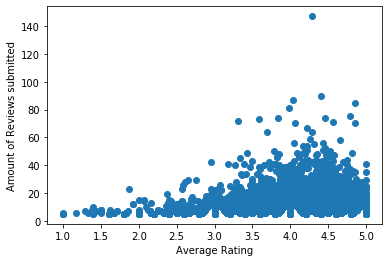

In [56]:
plt.scatter(x= order_cart_df['overall_list'].apply(np.mean), y= order_cart_df['overall_list'].apply(len))
plt.xlabel('Average Rating')
plt.ylabel('Amount of Reviews submitted')

Preserving only those that are under 2 standard deviations

In [52]:
(order_cart_df['overall_list'].apply(len) < (
    order_cart_df['overall_list'].apply(len).mean() + order_cart_df['overall_list'].apply(len).std()*2)).value_counts()

True     19133
False      723
Name: overall_list, dtype: int64

In [53]:
common_rev_len_df = order_cart_df[order_cart_df['overall_list'].apply(len)< (
    order_cart_df['overall_list'].apply(len).mean() + order_cart_df['overall_list'].apply(len).std()*2)]

Text(0, 0.5, 'Amount of Reviews submitted')

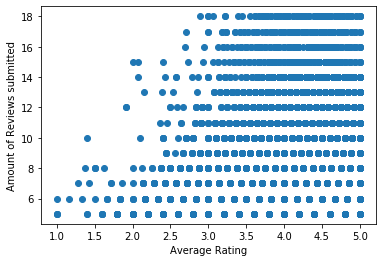

In [57]:
plt.scatter(x= common_rev_len_df['overall_list'].apply(np.mean), y= common_rev_len_df['overall_list'].apply(len))
plt.xlabel('Average Rating')
plt.ylabel('Amount of Reviews submitted')

In [62]:
common_rev_len_df['overall_list'].apply(len)

0         6
1         8
2        11
3         7
4         8
         ..
19851     6
19852     8
19853     5
19854     6
19855    10
Name: overall_list, Length: 19133, dtype: int64

There appears to be evidence that they are not correlated. In fact, we can investigate via boxplot and observe that review patterns don't seem to deviate significantly among those who review more.

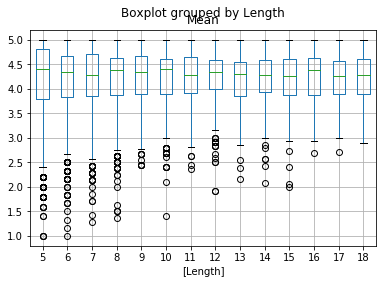

In [82]:
pd.DataFrame({'Length':common_rev_len_df['overall_list'].apply(len),'Mean':common_rev_len_df['overall_list'].apply(np.mean)}
            ).boxplot(by = 'Length')

Evaluating first purchases (or first reviewed) and what was their next purchase.

We will limit to the top twenty to make the subsequent visualization more manageable

In [83]:
first_two_purch_df = pd.DataFrame({'First_buy': order_cart_df['sub_category'].str[0],
                                   'Second_buy': order_cart_df['sub_category'].str[1]})

In [85]:
for col in ['overall_list', 'reviewTime_list']:
    first_two_purch_df[f'{col}_first'] = order_cart_df[col].str[0]
    first_two_purch_df[f'{col}_second'] = order_cart_df[col].str[1]

In [86]:
first_two_purch_df

,First_buy,Second_buy,overall_list_first,overall_list_second,reviewTime_list_first,reviewTime_list_second
0,Dogs_Litter & Housebreaking,B007X7FJAO,4,5,2014-04-24,2014-04-24
1,Dogs_Feeding & Watering Supplies,Dogs_Treats,5,1,2012-12-05,2012-12-31
2,B0002563HM,Fish & Aquatic Pets_Aquarium Pumps & Filters,5,5,2012-12-18,2012-12-18
3,Dogs_Toys,Dogs_Grooming,3,4,2013-07-18,2013-07-18
4,B001CQTOMG,B005AP3B88,4,5,2013-04-25,2013-04-25
...,...,...,...,...,...,...
19851,B002ZF06JI,B000QOHODG,5,5,2014-04-07,2014-06-04
19852,Cats_Toys,Cats_Food,5,5,2010-03-27,2011-10-20
19853,B007RQQKWC,B007TWREFG,5,5,2013-09-28,2013-09-29
19854,Dogs_Feeding & Watering Supplies,Dogs_Health Supplies,5,5,2011-09-12,2013-06-19


In [90]:
first_two_purch_df['First_buy'].value_counts()[:20].keys()

Index(['Dogs_Toys', 'Dogs_Treats', 'Cats_Litter & Housebreaking', 'Cats_Toys',
       'Dogs_Health Supplies', 'Cats_Beds & Furniture', 'Dogs_Grooming',
       'Cats_Health Supplies', 'Dogs_Collars, Harnesses & Leashes',
       'Cats_Feeding & Watering Supplies', 'Dogs_Feeding & Watering Supplies',
       'Cats_Food', 'Dogs_Litter & Housebreaking', 'Dogs_Food',
       'Fish & Aquatic Pets_Aquarium Pumps & Filters',
       'Dogs_Training & Behavior Aids', 'Dogs_Beds & Furniture',
       'Dogs_Carriers & Travel Products', 'Cats_Grooming', 'Cats_Treats'],
      dtype='object')

In [141]:
top_twenty_df = first_two_purch_df[np.logical_and(first_two_purch_df['First_buy'].isin( 
                                   list(first_two_purch_df['First_buy'].value_counts()[:20].keys())),
                                  first_two_purch_df['Second_buy'].isin( 
                                   list(first_two_purch_df['Second_buy'].value_counts()[:20].keys())))]

In [142]:
top_twenty_df

,First_buy,Second_buy,overall_list_first,overall_list_second,reviewTime_list_first,reviewTime_list_second
1,Dogs_Feeding & Watering Supplies,Dogs_Treats,5,1,2012-12-05,2012-12-31
3,Dogs_Toys,Dogs_Grooming,3,4,2013-07-18,2013-07-18
9,Dogs_Beds & Furniture,Cats_Beds & Furniture,5,5,2012-11-19,2012-11-19
10,Dogs_Treats,Dogs_Treats,5,5,2013-07-13,2013-07-13
18,Cats_Toys,Dogs_Toys,4,3,2013-11-12,2013-11-29
...,...,...,...,...,...,...
19815,Cats_Beds & Furniture,Dogs_Toys,4,4,2013-02-20,2013-03-08
19838,Cats_Grooming,Dogs_Treats,5,5,2010-05-13,2010-05-22
19843,Dogs_Treats,"Dogs_Collars, Harnesses & Leashes",5,5,2013-02-28,2013-02-28
19852,Cats_Toys,Cats_Food,5,5,2010-03-27,2011-10-20


In [143]:
top_twenty_df.groupby(['First_buy', 'Second_buy']).count()[['overall_list_second']]

overall_list_second
First_buy                                    Second_buy                                                       
Cats_Beds & Furniture                        Cats_Beds & Furniture                                          42
                                             Cats_Feeding & Watering Supplies                               10
                                             Cats_Food                                                      12
                                             Cats_Grooming                                                   7
                                             Cats_Health Supplies                                           20
...                                                                                                        ...
Fish & Aquatic Pets_Aquarium Pumps & Filters Dogs_Health Supplies                                            2
                                             Dogs_Toys                                                       4
                                             Dogs_Training & Behavior Aids                                   3
                                             Dogs_Treats                                                     4
                                             Fish & Aquatic Pets_Aquarium Pumps & Filters                   63

[380 rows x 1 columns]

Plotly Sankey will create a crazy looking cyclical flow so we'll need to add a string to the First Buy to avoid the issue.


(Cyclical flows look like "Dog Treat => Dog_Health", "Dog_Health" => "Dog_Treat")


Skip the next line to see what happens otherwise ... ;)

In [145]:
top_twenty_df['First_buy'] = top_twenty_df['First_buy'] + '1'

/home/drace/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [146]:
import plotly.graph_objects as go
import plotly.express as pex

all_nodes = top_twenty_df['First_buy'].values.tolist() + top_twenty_df['Second_buy'].values.tolist()
source_indices = [all_nodes.index(first) for first in top_twenty_df['First_buy']]
target_indices = [all_nodes.index(second) for second in top_twenty_df['Second_buy']]

colors = pex.colors.qualitative.D3

node_colors_mappings = dict([(node,np.random.choice(colors)) for node in all_nodes])
node_colors = [node_colors_mappings[node] for node in all_nodes]
edge_colors = [node_colors_mappings[node] for node in top_twenty_df['Second_buy']]


fig = go.Figure(data=[go.Sankey(
    # Define nodes
    node = dict(
      label =  all_nodes,
      color =  node_colors
    ),

    # Add links
    link = dict(
      source =  source_indices,
      target =  target_indices,
      value =  top_twenty_df.groupby(['First_buy', 'Second_buy']).count().reset_index()['overall_list_second'].values,
        color = edge_colors
))])

fig.update_layout(title_text="Map of First Purchased to Second Purchased Item", height=1000,
                  font_size=10)
fig.show()

More work in Progress (placeholder ;)  )

In [148]:
top_twenty_df['reviewTime_list_second'] - top_twenty_df['reviewTime_list_first']

1        26 days
3         0 days
9         0 days
10        0 days
18       17 days
          ...   
19815    16 days
19838     9 days
19843     0 days
19852   572 days
19854   646 days
Length: 4997, dtype: timedelta64[ns]